## Click Through Rate Prediction with PyTorch Lightning

In [306]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import gc

from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

AVAIL_GPUS = min(1, torch.cuda.device_count())

In [307]:
df = pd.read_csv("C:\\Users\\zjh\\PycharmProjects\\pythonProject1\\.venv\\input\\movielens1m\\ml-1m.train.csv", nrows=100_000)
test_df = pd.read_csv("C:\\Users\\zjh\\PycharmProjects\\pythonProject1\\.venv\\input\\movielens1m\\ml-1m.test.auc.csv")

In [308]:
test_df = test_df[test_df.userId.isin(set(df.userId).intersection(test_df.userId))]
test_df = test_df[test_df.movieId.isin(set(df.movieId).intersection(test_df.movieId))]

In [309]:
df.shape, test_df.shape

((100000, 9), (9954, 9))

### Re-encode

In [310]:
user_le = LabelEncoder()
item_le = LabelEncoder()

user_le.fit(df["userId"].values.tolist() + test_df["userId"].values.tolist())
item_le.fit(df["title"].values.tolist() + test_df["title"].values.tolist())


df["userId"] = user_le.transform(df["userId"])
df["movieId"] = item_le.transform(df["title"])

test_df["userId"] = user_le.transform(test_df["userId"])
test_df["movieId"] = item_le.transform(test_df["title"])

In [311]:
user_item_df = df[["userId", "movieId", "rating"]]
test_user_item_df = test_df[["userId", "movieId", "rating"]]
del df, test_df; gc.collect()

134

In [312]:
len(user_item_df.userId.unique()) * len(user_item_df.movieId.unique())

2193408

### Turn Rating Values to Binary CTR Variable


In [313]:
user_item_df["rating"] = 1
user_item_df["rating"] = user_item_df["rating"].astype(np.int8)

test_user_item_df["rating"] = 1
test_user_item_df["rating"] = test_user_item_df["rating"].astype(np.int8)

In [314]:
user_item_df = user_item_df.pivot_table(values="rating", index="userId", columns="movieId").fillna(0).unstack().reset_index().rename(columns={0:"rating"})
user_item_df["rating"] = user_item_df["rating"].astype(np.int8)
user_item_df["userId"] = user_item_df["userId"].astype(np.int16)
user_item_df["movieId"] = user_item_df["movieId"].astype(np.int16)

test_user_item_df = test_user_item_df.pivot_table(values="rating", index="userId", columns="movieId").fillna(0).unstack().reset_index().rename(columns={0:"rating"})
test_user_item_df["rating"] = test_user_item_df["rating"].astype(np.int8)
test_user_item_df["userId"] = test_user_item_df["userId"].astype(np.int16)
test_user_item_df["movieId"] = test_user_item_df["movieId"].astype(np.int16)

### Arrange Sample and Class Weighting Based on Item Frequencies

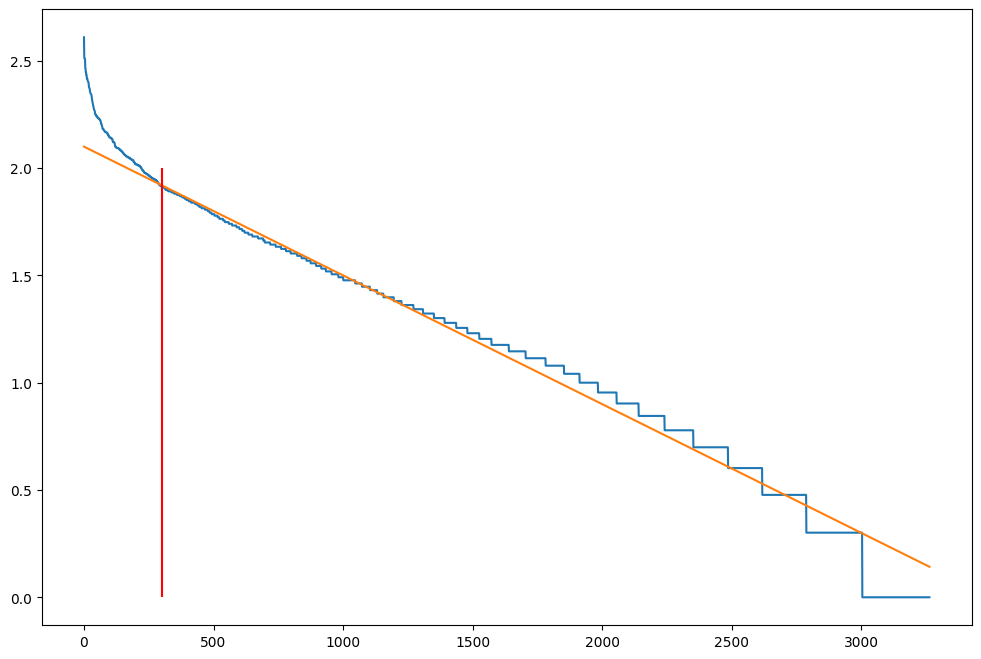

In [315]:
x = np.array(list(range(len(item_le.classes_))))

fig, ax = plt.subplots(figsize=(12, 8))
pd.DataFrame(user_item_df.groupby("movieId").rating.sum()).sort_values("rating", ascending=False).transform(np.log10).reset_index().rating.plot(ax=ax)
ax.plot(x, -0.0006*x+2.1)
ax.vlines(300, 0, 2, colors="red")

C:\Users\zjh\PycharmProjects\pythonProject1\.venv\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


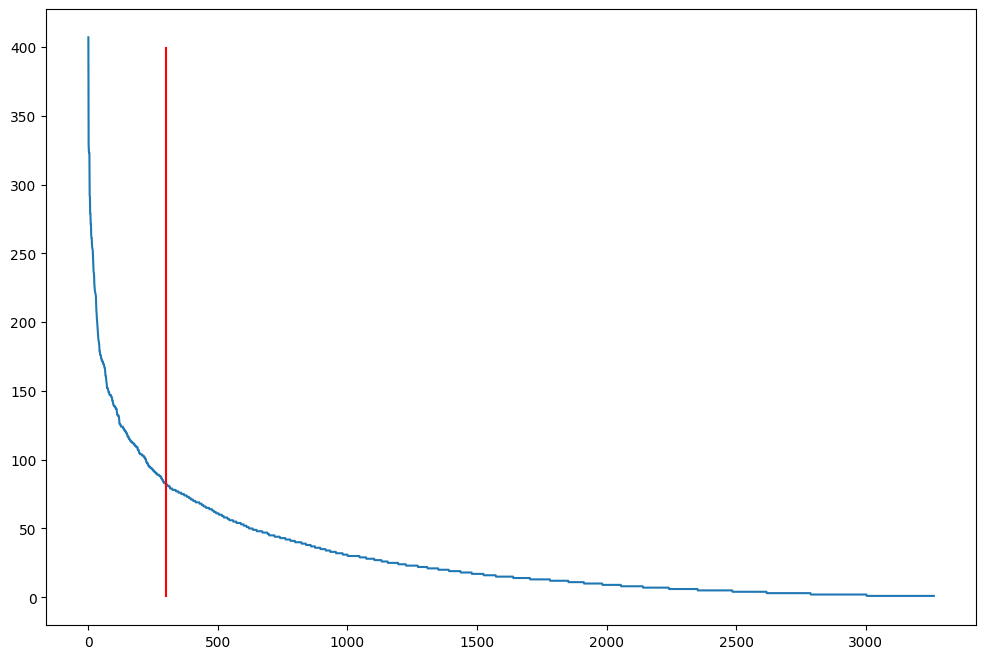

In [316]:
fig, ax = plt.subplots(figsize=(12, 8))
pd.DataFrame(user_item_df.groupby("movieId").rating.sum()).sort_values("rating", ascending=False).reset_index().rating.plot(ax=ax)
ax.vlines(300, 0, 400, colors="red")
#ax.vlines(100, 0, 400, colors="red")
#ax.vlines(1000, 0, 400, colors="red")
y = 1000 * 1/(x ** 0.3) - 100
#ax.plot(x, y)

- Items on the tail are less selected items. 
    - De-weight frequent items based on binned frequencies. (w_i < 1)
    - Uniformly weight tail items. (w_i = 1)

In [317]:
cutoff = 350
nbins = 7

In [318]:
movie_sum_df = pd.DataFrame(user_item_df.groupby("movieId").rating.sum()).sort_values("rating", ascending=False).reset_index()
most_common_df = movie_sum_df.iloc[:cutoff].rename(columns={"rating": "watch_count"})

In [319]:
bars, bins = np.histogram(most_common_df.watch_count, bins=nbins)

In [320]:
most_common_df["weight"]  = pd.cut(most_common_df.watch_count, bins=nbins, labels=bars).astype(np.int16)/np.max(bars)

In [321]:
movie_sum_df["weight"] = 1.0
movie_sum_df.loc[:cutoff - 1, "weight"] = most_common_df.weight
movie_sum_df.head(360)

,movieId,rating,weight
0,116,407.0,0.004630
1,2782,329.0,0.018519
2,1587,324.0,0.018519
3,2781,323.0,0.018519
4,2783,323.0,0.018519
...,...,...,...
355,1689,76.0,1.000000
356,3106,76.0,1.000000
357,2131,76.0,1.000000
358,2055,76.0,1.000000


In [322]:
user_item_df = user_item_df.merge(movie_sum_df[["movieId", "weight"]], how="left", on="movieId")
test_user_item_df = test_user_item_df.merge(movie_sum_df[["movieId", "weight"]], how="left", on="movieId")

In [323]:
user_item_df.shape, test_user_item_df.shape

((2193408, 4), (1448040, 4))

In [324]:
user_item_df.rating.value_counts()

0    2093408
1     100000
Name: rating, dtype: int64

In [325]:
test_user_item_df.rating.value_counts()

0    1438086
1       9954
Name: rating, dtype: int64

In [326]:
user_item_df.head()

,movieId,userId,rating,weight
0,0,0,0,1.0
1,0,1,0,1.0
2,0,2,0,1.0
3,0,3,0,1.0
4,0,4,0,1.0


In [327]:
class_weight = user_item_df.shape[0] / torch.Tensor([user_item_df.rating.value_counts()[0], user_item_df.rating.value_counts()[1]])
class_weight = class_weight/torch.norm(class_weight)

In [328]:
class_weight

tensor([0.0477, 0.9989])

### Implement AP@K Metric

In [329]:
def preds_to_df(user_item_df: pd.DataFrame, preds: torch.Tensor, k: int, 
                user_colname: str = "userId", 
                item_colname: str = "movieId",
                rating_colname: str = "rating",
                weight_colname: str = "weight"):
    
    _df = user_item_df[[user_colname, item_colname]].reset_index(drop=True)
    _df[rating_colname] = preds
    
    _df = _df.set_index(item_colname).groupby(user_colname).rating.nlargest(k).reset_index()
    
    _df[rating_colname] = 1
    
    pred_df = user_item_df[[user_colname, item_colname]].merge(_df, how="left", on=[user_colname, item_colname]).fillna(0)
    
    return pred_df
    

def precision_at_k(true_df: pd.DataFrame, pred_probas: torch.Tensor, k=5):
    """Order predicted probabilities of each user-item pair and select first k.
    
       Calculate Precision for k recommendations. 
       i.e. What ratio of the recommended items are interacted by the user.
       
       Average over users.
    """
    
    pred_df = preds_to_df(user_item_df=true_df, 
                          preds=pred_probas, 
                          k=k)
    
    #precision
    true = true_df.pivot_table(index="userId", columns="movieId")["rating"].reset_index().drop("userId", axis=1).fillna(0).values
    pred = pred_df.pivot_table(index="userId", columns="movieId")["rating"].reset_index().drop("userId", axis=1).fillna(0).values
    
    
    mean_precision_at_k = np.mean(np.sum(true*pred, axis=1) / np.sum(pred, axis=1))
    return mean_precision_at_k

def watched_from_recommended(test_df: pd.DataFrame,
                             test_probs: torch.Tensor,
                             user_colname: str = "userId",
                             item_colname: str = "movieId",
                             rating_colname: str = "rating",
                             k: int = 5):
    """Recall@K-like Metric for a single user-item interaction. Designed specifically for this problem's test set where
    a each user has only one interaction. 
    
    Return True if user's interacted item is in K recommendations.
    Average over all users.
    """
    
    test_df["preds"] = test_probs

    rec_df = test_df.set_index(item_colname).groupby(user_colname).preds.nlargest(5).reset_index().drop("preds", axis=1)
    watched_df = test_df[test_df.rating==1].sort_values(user_colname).reset_index(drop=True).drop(["preds", "rating"], axis=1)

    user_watched = []
    for user in watched_df[user_colname].unique():
        recomms = rec_df[rec_df[user_colname]==user][item_colname].values.tolist()
        watched = watched_df[watched_df[user_colname]==user][item_colname].values[0] in recomms
        user_watched.append(watched*1)
    
    return np.mean(user_watched)

### Implement Dataset

In [330]:
class ReviewDataset(Dataset):
    def __init__(self, 
                 source_df: pd.DataFrame, 
                 user_colname: str = "userId", 
                 item_colname: str = "movieId",
                 rating_colname: str = "rating",
                 weight_colname: str = "weight",
                 split: str ="train"):
        
        super(ReviewDataset, self).__init__
        self.df = source_df
        self.user_col = user_colname
        self.item_col = item_colname
        self.rating_col = rating_colname
        self.weight_col = weight_colname
        self.split=split
        
    def __getitem__(self, index: int):
        row = self.df.iloc[index]
        if self.split in ["train", "valid", "test"]:
            user = torch.Tensor([row.get(self.user_col)]).type(torch.int32)
            item = torch.Tensor([row.get(self.item_col)]).type(torch.int32)
            rating = torch.Tensor([row.get(self.rating_col)]).type(torch.int32).float()
            weight = torch.Tensor([row.get(self.weight_col)]).type(torch.int32)
            return user, item, rating, weight
        elif self.split == "inference": #For live
            user = torch.Tensor([row.get(self.user_col)]).type(torch.int32)
            item = torch.Tensor([row.get(self.item_col)]).type(torch.int32)
            weight = torch.Tensor([row.get(self.weight_col)]).type(torch.int32)
            return user, item, weight
        
    def __len__(self):
        return self.df.shape[0]

### Implement Lightning Module

In [331]:
class RecNN(pl.LightningModule):
    def __init__(self, 
                 num_users: int, 
                 num_items: int, 
                 latent_dim: int = 512, 
                 fc_layer_dims: list = [1024, 512, 128, 64],
                 train_frame: pd.DataFrame = user_item_df,
                 test_frame: pd.DataFrame = test_user_item_df,
                 valid_size: float = None,
                 user_colname: str = "userId",
                 item_colname: str = "movieId",
                 weight_colname: str = "weight",
                 class_weight: torch.tensor = class_weight,
                 seed: int = 7):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.latent_dim = latent_dim
        self.fc_layer_dims = fc_layer_dims
        self.train_frame = train_frame
        self.test_frame = test_frame
        self.valid_size = valid_size
        self.user_colname = user_colname
        self.item_colname = item_colname
        self.weight_colname = weight_colname
        self.class_weight = class_weight
        self.seed = seed
        
        #MF Part Components
        self.user_embedding_layer = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim)
        self.item_embedding_layer = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)
        
        self.mf_dropout = nn.Dropout(p=0.24)
        
        #MLP Part Components
        self.fc_layers = nn.ModuleList()
        for idx, (in_dim, out_dim) in enumerate(zip(self.fc_layer_dims[:-1], self.fc_layer_dims[1:])):
            self.fc_layers.append(nn.Linear(in_features=in_dim, out_features=out_dim))
        self.relu = nn.ReLU()
        self.mlp_dropout = nn.Dropout(p=0.34)
        
        #Output Components
        self.logits = torch.nn.Linear(in_features=self.fc_layer_dims[-1] + self.latent_dim, out_features=1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, user_ix, item_ix):
        user_embedding = self.user_embedding_layer(user_ix)
        item_embedding = self.item_embedding_layer(item_ix)
        
        #MF Part
        relevance_product = torch.mul(user_embedding, item_embedding)
        relevance_product = relevance_product.type_as(user_embedding)
        relevance_product = self.mf_dropout(relevance_product)
        
        #MLP Part
        user_item_embs = torch.cat([user_embedding, item_embedding], dim=-1)
        user_item_embs = user_item_embs.type_as(user_embedding)
        for idx, _ in enumerate(range(len(self.fc_layers))):
            user_item_embs = self.fc_layers[idx](user_item_embs)
            user_item_embs = self.relu(user_item_embs)
        user_item_embs = self.mlp_dropout(user_item_embs)
        
        #Output
        final_latent_rep = torch.cat([user_item_embs, relevance_product], dim=-1)
        logits = self.logits(final_latent_rep)
        #output = self.sigmoid(logits)
        return logits.squeeze(-1)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.2)
        return [optimizer], [lr_scheduler]
    
    def training_step(self, batch, batch_idx):
        user, item, rating, weight = batch
        pred_rating = self(user, item)
        loss = nn.BCEWithLogitsLoss(pos_weight=self.class_weight[1], reduction="mean")
        self.log("train_loss", loss(pred_rating, rating))
        return loss(pred_rating, rating)
    
    def validation_step(self, batch, batch_idx):
        user, item, rating, weight = batch
        pred_rating = self(user, item)
        loss = nn.BCEWithLogitsLoss(weight=weight, pos_weight=self.class_weight[1], reduction="mean")
        self.log("val_loss", loss(pred_rating, rating))
        return pred_rating
    
    def test_step(self, batch, batch_idx):
        user, item, rating, weight = batch
        pred_rating = self(user, item)
        loss = nn.BCEWithLogitsLoss(weight=weight, pos_weight=self.class_weight[1], reduction="mean")
        self.log("test_loss", loss(pred_rating, rating))
        return pred_rating
    
    def predict_step(self, batch, batch_idx):
        user, item, rating, weight = batch
        pred_rating = self(user, item)
        return pred_rating
    
    def validation_epoch_end(self, validation_step_outputs):
        logits = torch.hstack([l.squeeze(1) for l in validation_step_outputs])
        prob_preds = nn.Sigmoid()(logits)
        
        true_df = self.valid_dset.df
        if self.trainer.sanity_checking:
            true_df = true_df.iloc[:len(logits)]
        apk_score = precision_at_k(true_df, prob_preds, k=5)
        auc_score = roc_auc_score(true_df.rating, prob_preds, labels=[0, 1])
        
        self.log("val_score_apk", apk_score)
        self.log("val_score_auc", auc_score)
        
        return validation_step_outputs
    
    def test_epoch_end(self, test_step_outputs):
        logits = torch.hstack([l.squeeze(1) for l in test_step_outputs])
        prob_preds = nn.Sigmoid()(logits)
        true_df = self.test_dset.df
                
        apk_score = precision_at_k(true_df, prob_preds, k=5)
        auc_score = roc_auc_score(true_df.rating, prob_preds, labels=[0, 1])
        
        self.log("test_score_apk", apk_score)
        self.log("test_score_auc", auc_score)
        
    def setup(self, stage=None):
        if stage=="fit":
            if self.valid_size:
                train_ix, valid_ix = list(StratifiedShuffleSplit(n_splits=1, test_size=self.valid_size, random_state=self.seed).split(self.train_frame[self.user_colname], self.train_frame[self.user_colname]))[0]
                train_df, valid_df = self.train_frame.iloc[train_ix].reset_index(), self.train_frame.iloc[valid_ix].reset_index()
                
                self.valid_dset = ReviewDataset(source_df=valid_df,
                                                user_colname=self.user_colname,
                                                item_colname=self.item_colname,
                                                split="valid")
            else:
                train_df = self.train_frame
                
            self.train_dset = ReviewDataset(source_df=train_df,
                                            user_colname=self.user_colname,
                                            item_colname=self.item_colname,
                                            split="train")
            
        elif stage=="test":
            self.test_dset = ReviewDataset(source_df=self.test_frame, 
                                           user_colname=self.user_colname,
                                           item_colname=self.item_colname,
                                           split="test")
            
        elif stage=="predict":
            self.inference_dset = ReviewDataset(source_df=self.test_frame, 
                                                user_colname=self.user_colname,
                                                item_colname=self.item_colname,
                                                split="test")
            
    def train_dataloader(self):
        return DataLoader(self.train_dset, batch_size=256, shuffle=True, num_workers=0)
    
    def val_dataloader(self):
        if self.valid_size:
            return DataLoader(self.valid_dset, batch_size=256, num_workers=0)
        else:
            pass
        
    def test_dataloader(self):
        return DataLoader(self.test_dset, batch_size=256, num_workers=0)
    
    def predict_dataloader(self):
        return DataLoader(self.test_dset, batch_size=256, num_workers=0)
    
    #test_epoch_end for metrics

### Train

In [332]:
model = RecNN(num_users=len(user_item_df.userId.unique()), 
              num_items=len(user_item_df.movieId.unique()),
              valid_size=0.2)

early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=True)

trainer = pl.Trainer(
    callbacks=[early_stop],
    accelerator='cpu',
    max_epochs=15,
)

trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | user_embedding_layer | Embedding  | 344 K 
1 | item_embedding_layer | Embedding  | 1.7 M 
2 | mf_dropout           | Dropout    | 0     
3 | fc_layers            | ModuleList | 598 K 
4 | relu                 | ReLU       | 0     
5 | mlp_dropout          | Dropout    | 0     
6 | logits               | Linear     | 577   
7 | sigmoid              | Sigmoid    | 0     
----------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.458    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\zjh\PycharmProjects\pythonProject1\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
C:\Users\zjh\PycharmProjects\pythonProject1\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.110


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.107


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.104


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.101


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.101. Signaling Trainer to stop.


### Validate Checkpoint

In [333]:
valid_scores = trainer.validate()

C:\Users\zjh\PycharmProjects\pythonProject1\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:128: UserWarning: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  + f" You can pass `.{fn}(ckpt_path='best')` to use the best model or"
Restoring states from the checkpoint path at C:\Users\zjh\PycharmProjects\pythonProject1\lightning_logs\version_6\checkpoints\epoch=6-step=47985.ckpt
Loaded model weights from checkpoint at C:\Users\zjh\PycharmProjects\pythonProject1\lightning_logs\version_6\checkpoints\epoch=6-step=47985.ckpt
C:\Users\zjh\PycharmProjects\pythonProject1\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many

Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.10989537090063095
      val_score_apk         0.4758928571428572
      val_score_auc         0.9022402312127743
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Test Checkpoint

In [334]:
test_scores = trainer.test()

C:\Users\zjh\PycharmProjects\pythonProject1\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:128: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  + f" You can pass `.{fn}(ckpt_path='best')` to use the best model or"
Restoring states from the checkpoint path at C:\Users\zjh\PycharmProjects\pythonProject1\lightning_logs\version_6\checkpoints\epoch=6-step=47985.ckpt
Loaded model weights from checkpoint at C:\Users\zjh\PycharmProjects\pythonProject1\lightning_logs\version_6\checkpoints\epoch=6-step=47985.ckpt
C:\Users\zjh\PycharmProjects\pythonProject1\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers wh

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.08949657529592514
     test_score_apk         0.08727272727272728
     test_score_auc         0.9050048818096594
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Save Checkpoint

In [335]:
trainer.save_checkpoint("./rec_sys_ctr.ckpt")